In [1]:
import numpy as np
import autolens as al
import autogalaxy as ag
import autolens.plot as aplt
import os
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from autolens.plot import MatPlot2D

# from photutils import DAOStarFinder, CircularAperture
from astropy.stats import sigma_clipped_stats
# from autolens.plot import ArrayPlotter
%load_ext autoreload

import sys
from pathlib import Path

base_dir = Path.cwd()
autolens_config_path = base_dir / "autolens_config"
spherex_path = base_dir / "SPHEREx"

sys.path.append(str(autolens_config_path))
sys.path.append(str(spherex_path))


#import gcluster15  # from autolens_config
import SPHERExScripts as SPHEREx  # from SPHEREX
import gcluster16 as galaxy
import autolens_config



2025-03-04 17:54:17,395 - numexpr.utils - INFO - Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-03-04 17:54:17,396 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [2]:
%autoreload 2
!nproc

20


## Here are some properties about the galaxy clusters we are studying and simulating I want to note 
***

First of all, we want to look at *rich* galaxy clusers (N_gal >= 30). Rich galaxy clusters are known to be proponents of strong lensing. We can see this from the papers:
- [https://ui.adsabs.harvard.edu/abs/2011RAA....11.1185W/]
- [https://ui.adsabs.harvard.edu/abs/2009RAA.....9....5W/]
- [https://ui.adsabs.harvard.edu/abs/2014SCPMA..57.1809L/]

However, we need some way to parametrize the mass and light given the number of galaxies and redshift. After all, we are creating mass and light profiles so that PyAutoLens can perform raytracing. 

We can use the results from [https://iopscience.iop.org/article/10.1086/444554/pdf]:
* $R^{N}_{200} \sim N^{0.6}_{gal}$, powerlaw related by index $\approx -0.6$

* $M_{200} \sim N^{1.8}_{gal}$ 

* $M^{1/3}_{200} \sim N^{1/3\alpha\beta}_{gal}$ where $(1/3\alpha\beta) \approx 0.6$ and $\beta$ in the range $\sim 0.5 - 0.65$ and $\alpha$ ranges depending on $N_{gal}$, but $\alpha =-1$ for $N_{gal} > 8$
Where $R^{N}_{200}$ is the characteristic radius, $N_{gal}$ is the cluster richness, and the $200$ subscript denotes the virial term. 


Now, we need to model the dark matter halo. Going off what Cooray said, we can have the dark matter halo as about 30" in radius. However, It would be better if we had a better estimate related to the number of galaxies. 

We can describe the dark matter profile of a galaxy using an NFW:
- [https://iopscience.iop.org/article/10.1086/500288/pdf]
- [https://arxiv.org/pdf/astro-ph/9508025]
- [https://iopscience.iop.org/article/10.1088/0004-637X/729/2/127/pdf]
- [https://iopscience.iop.org/article/10.1086/308744/pdf]


We also need to figure out how to distribute the galaxies within the plane of the 2D image. We can use the standard power law formula for the distribution:
- $n(R) \propto (1 + R/R_c)^{-\alpha}$

where $R$ is the cluster centric radius (the distance from the galaxy to the center of the cluster, which in our case will always be the center of the plane) and $R_c$ is the cluster radius. 

---
#### Simulation
Since PyAutoLens does not have formal support for creating galaxy clusters, we have to create each individual galaxy. We can break this down into mass profiles, and light profiles. 

In the case of the mass profile, the NFW dark matter halo will dominate the galaxy cluster's mass distribution. The percentage that it take is approximately 90%.
- (https://ui.adsabs.harvard.edu/abs/1996ApJ...462..563N/abstract)
- (https://www.mdpi.com/2075-4434/7/1/8)
- (https://www.nature.com/articles/s41586-020-2642-9)
Therefore, we can accurately model the mass profile with the dark matter halo NFW. Perhaps we can try adding in a small correction due to some extraneously dense galaxy, but such an implementation is not necessary for now. 

I am not entirely sure how to model this off based on the number of galaxies. I'm not sure if it should


We also need to model the light profile. This one is more tricky, for obvious reasons. 
Naively, we can create a random sersic light profile for every single galaxy in the cluster, add all the galaxies to our galaxy cluster, and we have a light profile for our cluster. However, this is computationally expensive and not exactly accurate. 

Here are some facts we know about galaxy clusters, their member galaxies and their light profiles. 
- They can be described by sersic profiles

- There exists a "brightest" galaxy within the cluster, positioned near the center of the cluster, which can take up to 36% of the total light profile. (https://arxiv.org/pdf/astro-ph/0001415)

- There are a range of luminous galaxy members, but we will proceed by truncating their contributions under a certain apparent magnitude. This is to reduce computaional intensity. We can allow the medium range luminous galaxies to have a light profile within a certain random range. 


Now, we need to get the flux to pixel ratio correct. After all, these are going to be placed into the background of images from the merged catalog of DESI + Subaru legacy surveys. 
From what I can see, this has to be aligned with the pixel scales from marco's images. 


### Imaging details

So far we have mostly been talking about the positions, distributions, mass and light profiles of the galaxies. However, now we need to focus more specifically on how to create a largely lensed arc. We also need to focus on specifically the details with SPHEREx, and how we are going to process the data that comes in 102 bands from SPHEREx. 


To create a largely lensed arc there are two significant ways that we consider: 
- lensing by a significantly large mass profile and thereby einstein ring. This will create a large arc in the sky that we can create rather easily by placing the source behind the lens and letting the mass profile of the dark matter halo go to work. 
- lensing by extremities in the source position. I.e. that the profiles of the galaxies within the cluster have an intrinsic critical curve associated with them. This allows for extreme lensing at the positions in the sky where the critical curves and caustic profiles reach their extremeties. 

We plan to incorporate both of these methods of generating large arcs to train the neural network. 


Since we are considering images and data from SPHEREx, we have to consider the fact that SPHEREx data is in 102 bands. We have to account for all of these bands. Specifically, some visual bands can help with galaxy cluster detection with a lensed arc. For example, galaxy clusters are notoriously red, compared to other other observational objects. A lensed source galaxy appearing will appear more blue and surround the red galaxy cluster, leading to a way to visually detect an arc without seeing a clear arc. 

We are still working on how to incorporate all of these bands. 



In [3]:
# imageRaw = galaxy.wrapperFunction()

Datasets in file: ['raw_outputs']
Single image shape: (1259, 1259)


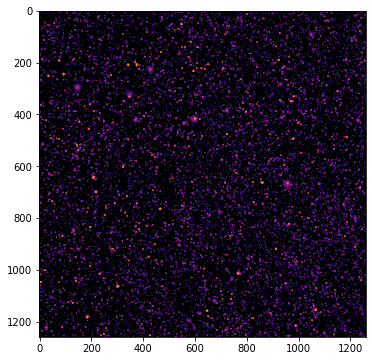

In [3]:
# file_path = "output/simulatedBackgrounds395pixels.h5"
file_path = "/home/marco/largeOutputs/simulated64pixBackgrounds.h5"

with h5py.File(file_path, "r") as h5_file:
    # List available datasets
    print("Datasets in file:", list(h5_file.keys()))
    
    dataset_name = list(h5_file.keys())[0]  # Select the dataset, should be called raw_data
    images = h5_file[dataset_name][()]  # Load the dataset into a NumPy array

# Display the first image
norm = mpl.colors.SymLogNorm(linthresh=0.005)

print(f"Single image shape: {images[1].shape}")

plt.figure(figsize=(6, 6))
plt.imshow(images[1], cmap="inferno", norm=norm)  # Assuming grayscale images
# plt.colorbar()
# plt.title("First Image in simulated1.h5")
plt.show()

In [3]:
import sys
from pathlib import Path

base_dir = Path.cwd()
autolens_config_path = base_dir / "autolens_config"

sys.path.append(str(autolens_config_path))


#import gcluster15  # from autolens_config
import gcluster16 as galaxy
import autolens_config
%autoreload 2

Datasets in file: ['raw_outputs']
number of galaxies: 24


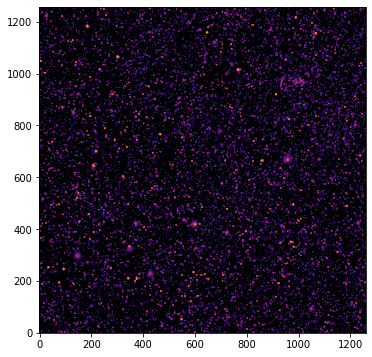

In [4]:
%autoreload 2

file_path = "/home/marco/largeOutputs/simulated64pixBackgrounds.h5"

with h5py.File(file_path, "r") as h5_file:
    # List available datasets
    print("Datasets in file:", list(h5_file.keys()))
    
    dataset_name = list(h5_file.keys())[0]  # Select the dataset, should be called raw_data
    images = h5_file[dataset_name][()]  # Load the dataset into a NumPy array
    
background = images[1]
fake = np.array([None, None])
multiple = False
canvas_size = 0.6*images[1].shape[1]

# n = 10 # 10 for single clusters, not multiple
# # n = 3
if multiple == False:
    n = int(np.random.uniform(10,30))
else:
    #n = int(np.random.uniform(3,6))
    n=3

print(f"number of galaxies: {n}")
combined_raw = galaxy.wrapperFunction(n, background, multiple, canvas_size)

# background = images[0]
# overlay_image = background + imageRaw

plt.figure(figsize=(6, 6))

plt.imshow(combined_raw, cmap="inferno", origin="lower", norm=mpl.colors.SymLogNorm(linthresh=0.005))
# plt.show()
# plt.imshow(combined_raw_zoom, cmap="inferno", origin="lower", norm=mpl.colors.SymLogNorm(linthresh=0.005))

# plt.set_title("Cluster Overlaid on Background")
# plt.set_xlabel("X Coordinate")
# plt.set_ylabel("Y Coordinate")
# plt.colorbar(label="Intensity")

# plt.tight_layout()
plt.show()


In [5]:
import h5py

with h5py.File("lensed_images.h5", "a") as f:
    dataset_name = f"image_{len(f.keys())}"
    f.create_dataset(dataset_name, data=combined_raw)
    #f.create_dataset("image2", data=another_image_array)  # Add more images

Number of keys in the HDF5 file: 23


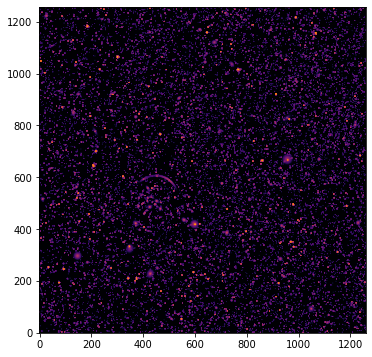

In [9]:
with h5py.File("lensed_images.h5", "r") as f:
    # image1 = f["image1"][:]
    num_keys = len(f.keys())  # Count the number of top-level keys
    print(f"Number of keys in the HDF5 file: {num_keys}")

    # Images are indexed starting at image_0
    image2 = f["image_22"][:]

plt.figure(figsize=(6, 6))

plt.imshow(image2, cmap="inferno", origin="lower", norm=mpl.colors.SymLogNorm(linthresh=0.005))
# plt.set_title("Cluster Overlaid on Background")
# plt.set_xlabel("X Coordinate")
# plt.set_ylabel("Y Coordinate")
# plt.colorbar(label="Intensity")

# plt.tight_layout()
plt.show()

In [134]:
from astropy.io import fits
from scipy.signal import correlate
def processImg(raw_image, psf_file='SPHEREx/psf_data/simulated_PSF_2DGaussian_1perarray.fits', psf_length=54,target_resolution=3.1):
    """
    Processes an image for SPHEREx by convolving it with a PSF and binning the result.


    """
    # Open the FITS file and extract PSF data
    hdul = fits.open(psf_file)
    hdu_psf = hdul[42]
    reso_ratio = int(target_resolution/ hdu_psf.header['HIERARCH platescale'])
    psf = hdu_psf.data
    hdul.close()

    # Crop and normalize the PSF
    c = int(psf.shape[0] / 2)
    psf = psf[c - psf_length:c + psf_length, c - psf_length:c + psf_length]
    psf = psf / np.sum(psf)

    # Convolve raw image with PSF
    convolved = correlate(raw_image, psf, mode='valid')

    # Bin the image
    def bin2d(img, ratio):
        m_bins = img.shape[0] // ratio
        n_bins = img.shape[1] // ratio
        img_binned = img.reshape(m_bins, ratio, n_bins, ratio).sum(3).sum(1)
        img_binned /= ratio**2
        return img_binned

    binned = bin2d(convolved, reso_ratio)

    return convolved, binned

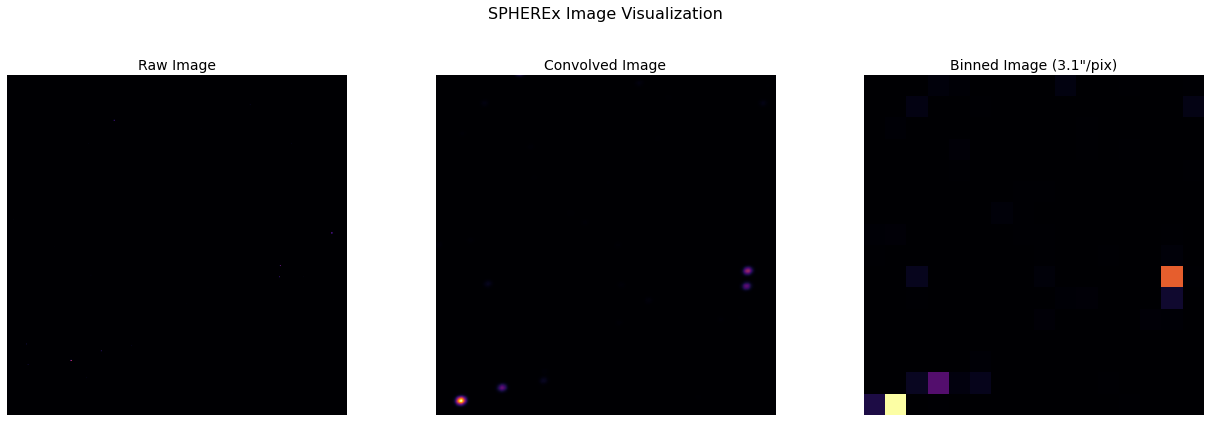

In [137]:
convolved, binned = processImg(combined_raw, target_resolution=6.2)
SPHEREx.plotImg(raw_image=combined_raw,convolved=convolved,binned=binned)

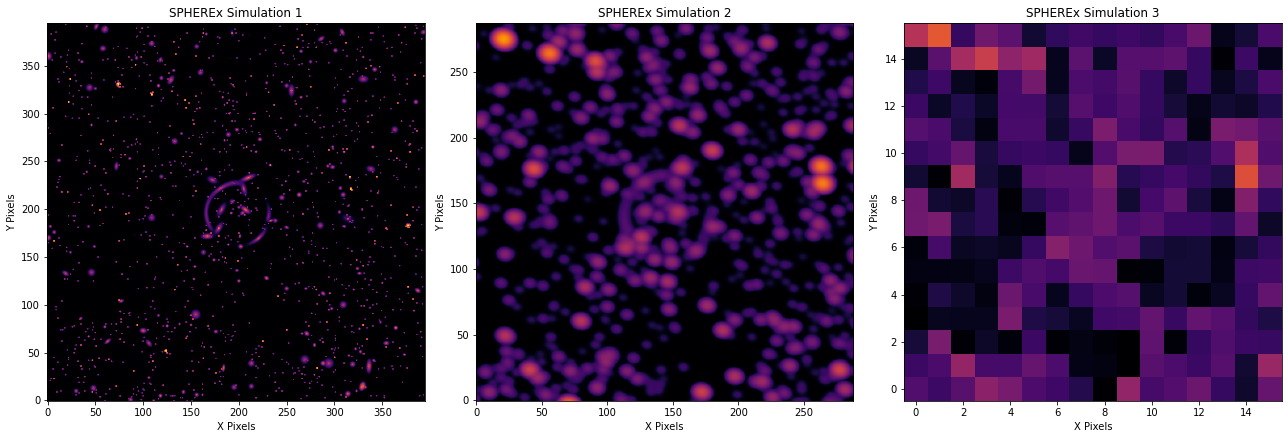

In [138]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Example data (replace with your actual images)
data1, data2, data3 = combined_raw, convolved,binned  # Replace with actual image data

norm = mpl.colors.SymLogNorm(linthresh=0.005)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# List of data and titles
data_list = [data1, data2, data3]
titles = ["SPHEREx Simulation 1", "SPHEREx Simulation 2", "SPHEREx Simulation 3"]

for i, ax in enumerate(axes):
    im = ax.imshow(data_list[i], cmap='inferno', origin='lower', norm=norm)
    ax.set_title(titles[i])
    ax.set_xlabel("X Pixels")
    ax.set_ylabel("Y Pixels")

# Add a single colorbar for all subplots
#fig.colorbar(im, ax=axes.ravel().tolist(), label="Flux")

plt.tight_layout()
plt.show()

## Citations
- https://ui.adsabs.harvard.edu/abs/2011RAA....11.1185W/
- https://ui.adsabs.harvard.edu/abs/2009RAA.....9....5W/
- https://ui.adsabs.harvard.edu/abs/2014SCPMA..57.1809L/
- https://iopscience.iop.org/article/10.1086/444554/pdf
- https://arxiv.org/pdf/1809.03325
- https://www.frontiersin.org/journals/astronomy-and-space-sciences/articles/10.3389/fspas.2024.1411810/full
- https://arxiv.org/pdf/2111.08721
- https://arxiv.org/pdf/2111.08721
- https://www.aanda.org/articles/aa/full_html/2013/07/aa21268-13/aa21268-13.html
- https://iopscience.iop.org/article/10.1086/340952/pdf
- https://www.researchgate.net/figure/The-Sersic-profile-equation-1-describes-how-a-galaxy-light-profile-varies-as-a-function_fig2_234382030
- https://arxiv.org/pdf/astro-ph/0001415
- https://www.aanda.org/articles/aa/full_html/2021/05/aa40245-20/aa40245-20.html
- 

In [ ]:
# Below is code that shouldnt be run

In [ ]:
# Testing caustics

In [26]:
import autolens as al
import autolens.plot as aplt
import matplotlib.pyplot as plt
import os

# Define and ensure output directory
output_dir = "./output"
output_filename = "test1_output"
os.makedirs(output_dir, exist_ok=True)

# Set the PyAutoLens config directory (to override potential config issues)
# aplt.conf.instance.visualize_path = output_dir
# aplt.conf.instance.output_path = output_dir

# Define the lens galaxy with a mass profile
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.Isothermal(centre=(0.0, 0.0), einstein_radius=1.5, ell_comps=(0.0, 0.1))
)

# Define a grid of image-plane coordinates
grid = al.Grid2D.uniform(shape_native=(100, 100), pixel_scales=0.05)

# Create a Tracer object that combines the lensing effects
tracer = al.Tracer(galaxies=[lens_galaxy])
convergence = tracer.convergence_2d_from(grid=grid)


# Set up the MatPlot2D to customize the figure
# tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)

# 4. Extract the caustics from the tracer.
# The caustics are computed by mapping the critical curves into the source-plane.
# Depending on your version, the available methods are:
# 4. Extract the caustics from the tracer.
# These methods compute the source-plane caustics corresponding to the image-plane critical curves.
radial_caustics = tracer.radial_caustic_list_from(grid=grid)
tangential_caustics = tracer.tangential_caustic_list_from(grid=grid)

# 5. Create a Visuals2D instance and pass in the caustics with the correct keyword arguments.
visuals = aplt.Visuals2D(
    radial_caustics=radial_caustics,
    tangential_caustics=tangential_caustics,
)

# 🔹 7. Configure MatPlot2D for saving (✅ This is the proper way to save in PyAutoLens)
mat_plot = aplt.MatPlot2D(
    output=aplt.Output(
        path=output_dir,  # Explicitly set path
        filename=output_filename,
        format="png",  # Save as PNG (change to "jpg", "pdf" if needed)
        bbox_inches="tight"  # Ensures the plot is cropped properly
    )
)


array_plotter = aplt.Array2DPlotter(
    array=convergence, 
    visuals_2d=visuals, 
    mat_plot_2d=mat_plot
)
array_plotter.figure_2d()

saved_image_path = os.path.join(output_dir, f"{output_filename}.png")
if os.path.exists(saved_image_path):
    print(f"✅ Image successfully saved at: {saved_image_path}")
else:
    print("❌ Error: Image was NOT saved. Check your settings.")



✅ Image successfully saved at: ./output/test1_output.png
